# Deep Learning & Art : Neural Style Transfer
- We will be able to :
    - Implemnent the neural sytle transfer algorithm
    - Generate novel artistic images using our algorithm
    - Define the style cost function for Neural Style Transfer.
    - Define the content cost function for Neural Style Transfer.
- Most of the algorithms we've studies optimize a cost function to get a set of parameter values. With Neural Style Transfer, we'll get to optimize a cost function to get pixel values.

# 1. Packages

In [2]:
import os
import sys
import scipy.io
import scipy.misc
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint

# 2. Problem Statement
- Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges 2 images, namely : a 'content' image (C) and a 'style' image (S) to create a 'generated' image (G). The generated image G combines the 'content' of the image C with the 'style' of image S.
- 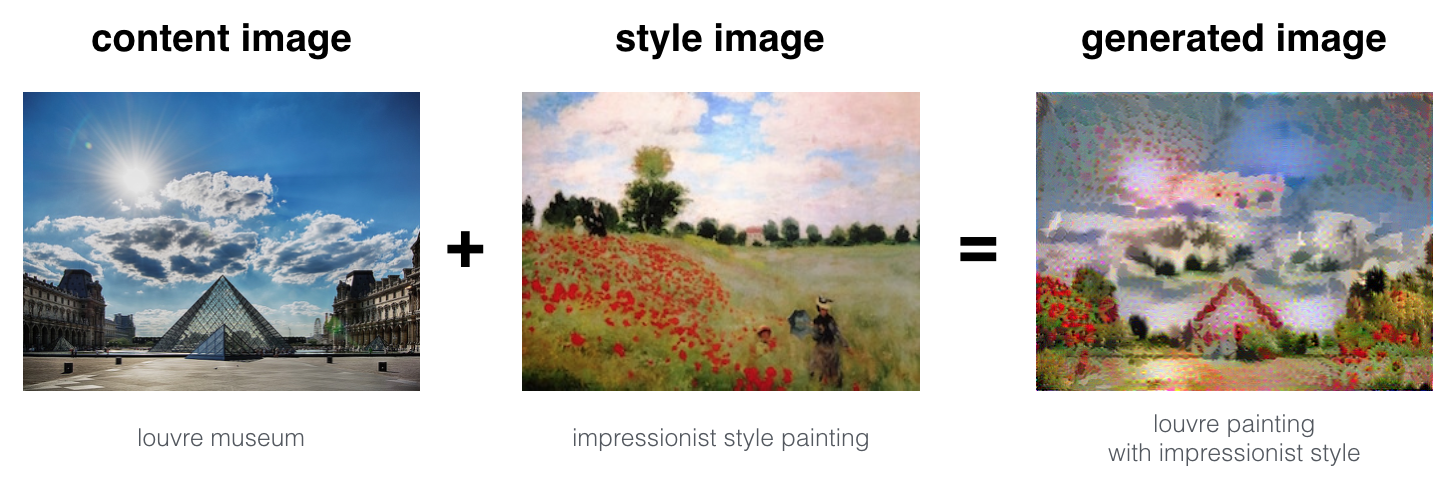

# 3. Transfer Learning
- Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning.
- we will be using the eponymously named VGG network from the original NST paper. We'll use VGHG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learbed to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers).

In [6]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights=r'PreTrainedModel\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

# 4. Neural Style Transfer (NST)
- We will be building the Neural Style Transfer (NST) algorithm in 3 steps:
    1. We will build the content cost function J_content(C, G)
    2. We will build the style cost function J_style(S, G)
    3. Finally, we'll put it all together to get J(G) = alpha*J_content(C, G) + beta*J_style(S, G)
    
## 4.1 Computing the Content cost
### 4.1.1 Make Generated Image G Match the Content of Image C
- One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. To do so, we'll need an understanding of shallow versus deep layers :
    - The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
    - The deeper layers tend to detect higher-level features such as more complex textures and object classes.
### To choose a 'middle' activation layer a[l]
- We need the 'generated' image G to have similar content as the input image C. Suppose we have chosen some layer's activations to represent the content of an image.
    - We will usually get the most visually pleasing results if we choose a layer from somewhere in the middle of the network-neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
    - Experiment with using different layers to see how the results vary!
### To forward propagate image 'C':
- Set the image C as the input to the pretrained VGG network, and run forward propagation
- Let a^(C) be the hidden layer activations in the layer we had chosen. a[l](C). This will be an n_H x n_W x n_C tensor.
### To forward propagate image 'G':
- Repeat this proecess with the image G: Set G as the input and run forward propagation.
- Let a^(G) be the corresponding hidden layer activation.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


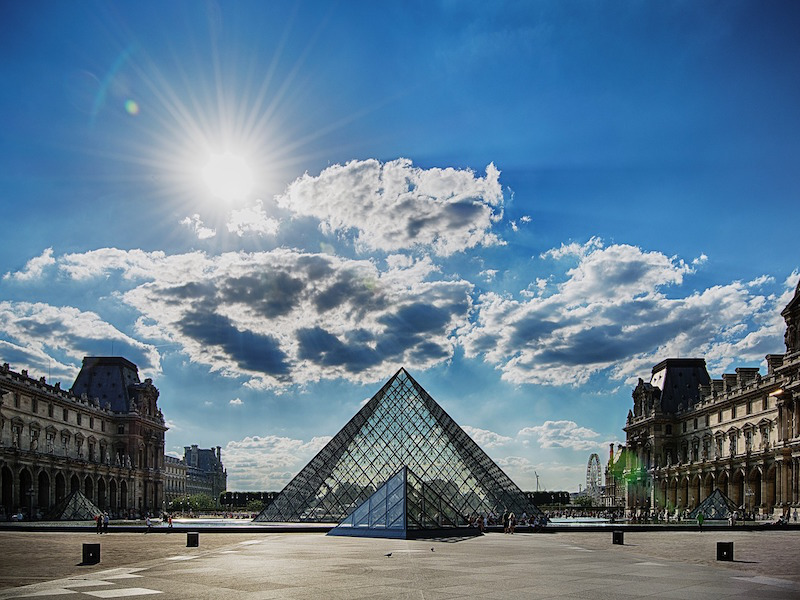

In [7]:
content_image = Image.open(r'images/louvre.jpg')
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

### 4.1. Content Cost Funtion J_content(C, G)
- One goal we should aim for when performing NST is for the content in generated image G to match the content of image C. A method to achieve this is calculated the content cost function, which will be defined as :
    - 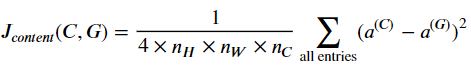
- n_H, n_W, n_C are the height, width and number of channels of the hidden layer we have chosen, and appear in a normalization term in the cost.
- For clarity, note that a^(C) and a^(G) are the 3D volumes corresponding to a hidden layer's activations.
- In order to compute the cost J_content(C, G) it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below
- This unrrolling step isn't need to compute J_content, but it will be good practice for when we do need to carry out a similar operation later for computing the style cost J_style.
- 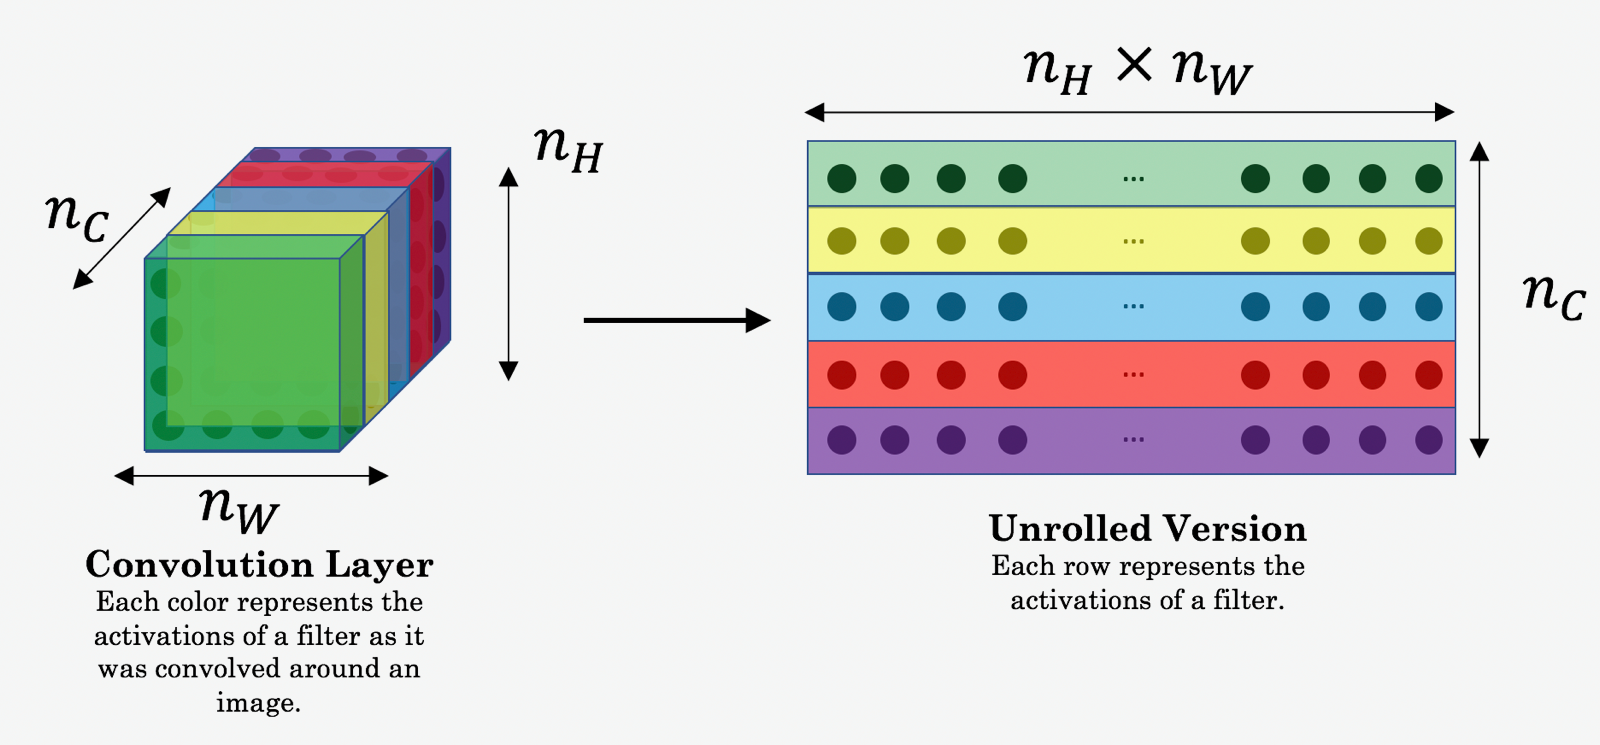

### Compute_content_cost() function
- Compute the 'content cost' using TensorFlow
- a_G : hidden layer activations representing content of the image G.
- a_C : hidden layer activations representing content of the image C.
- The steps to implement the function are :
    1. Retreive dimensions from a_G :
        - To retrieve dimensions from a tensor X, use : X.get_shape().as_list()
    2. Unroll a_C and a_G as 
        - We'll likely want to use these functions : tf.transpose and tf.reshape
    3. Compute the content cost :
        - We'll likely want to use the functions : tf.reduce_sum, tf.square and tf.subtract
- For unrolling
    - To unroll the tensor, we want the shape to change from (m, n_H, n_W, n_C) to (m, n_H x n_W x n_C).
    - tf.reshape(tensor, shape) takes a list of integers that represent the desired output shape.
    - For the shape parameter, a -1 tells the function to choose the correct dimension size so that the output tensor still contains all the values of the original tensor.
    - tf.reshape(a_C, shape=[m, n_H * n_W * n_C]) gives the same result as tf.reshape(a_C, shape=[m, -1, n_C])
    - If we prefer to re-order the dimensions, we can use tf.transpose(tensor, perm) where perm is a list of intergers containing the original index of the dimensions.
    - For example, tf.transpose(a_C, perm=[0, 3, 1, 2]) changes the dimensions from (m, n_H, n_W, n_C) to (m, n_c, n_H, n_W)

In [9]:
def compute_content_cost(content_output, generated_output):
    '''
    Computes the content cost
    
    Arguments :
        a_C : Tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
        a_G : Tensor of dimension (1, n_H, n_W, n_C), hidden layer acivations representing content of the image G
        
    Returns :
        J_content : Scalar that we compute using equation
    '''
    
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape 'a_C' and 'a_G'
    # DO NOT reshape 'content_output' or 'generated_output'
    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    # compute the cost with tensorflow 
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))
    
    return J_content

- The content cost takes a hidden layer activation of the neural network, and measures how different a^(C) and a^(G) are.
- When we minimize the content cost, this will help make sure G has similar content as C.

## 4.2 Computing the Style Cost

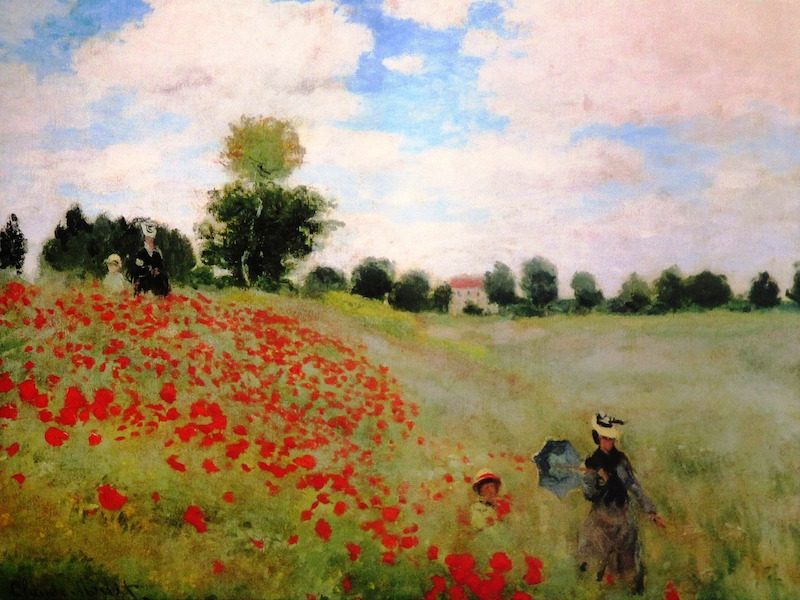

In [10]:
example = Image.open(r'images/monet_800600.jpg')
example

### 4.2.1 Style Matrix
- Gram matrix 
    - The style matrix is also called a 'Gram matrix'
    - In linear algebra, the Gram matrix G of a set of vectors (v1, ...,vn) is the matrix of dot products, whose entries are 
    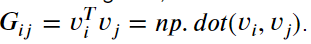
    - In other words, G_i,j compares how similar v_i is to v_j : If they are highly similar, we would expect them to have a large dot product, and thus G_i,j to be large.
- Two meaning of the variable G
    - Note that there is an unfortunate collision in the variable names used here. Following the common terminology used in the literature :
        - G is used to denote the style matrix or Gram matrix
        - G also denotes the generated image
    - For the sake of clarity, G_gram wil be used to refer to the Gram matrix and G to denote the generated image.

### Compute Gram matrix G_gram
- We will compute the Style matrix by multiplying the 'unrolled filter' matrix with its transpose.
- 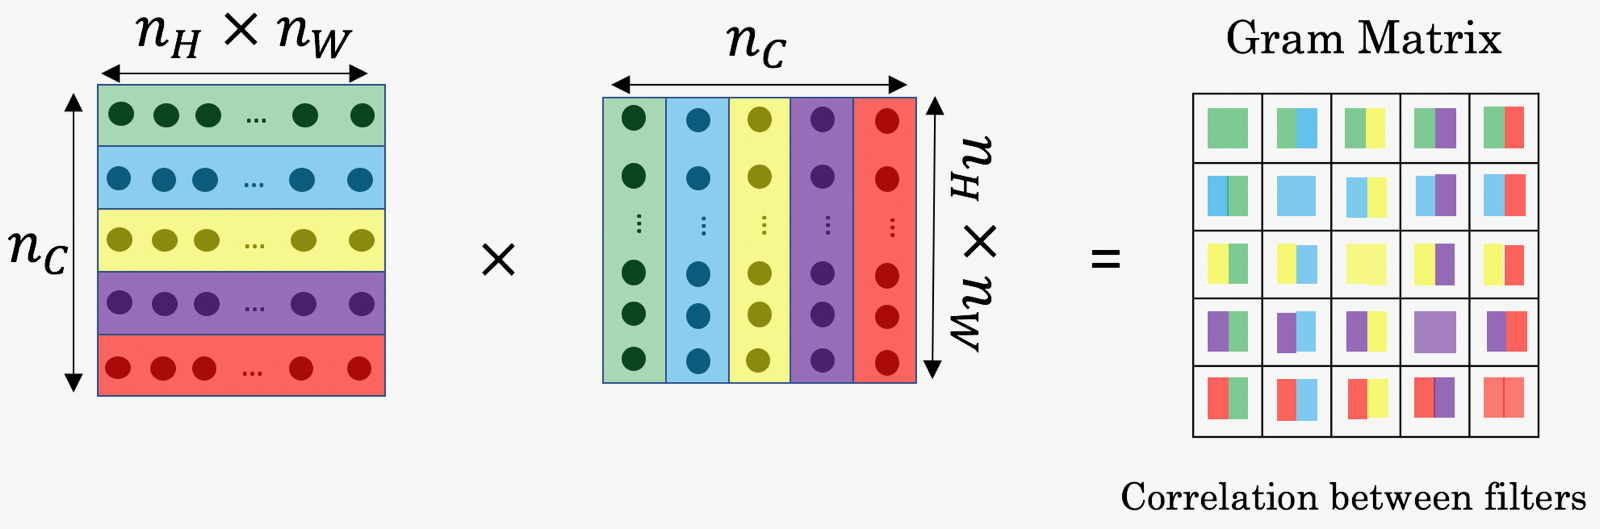

### G(gram)_i,i : prevalence of patterns or textures
    - The diagonal element G(gram)_ii measures how 'active' a filter i is.
    - For examples, suppose filter i is detecting vertical textures in the image. Then G(gram)_ii measures how common vertical textures are in the image as a whole.
    - If G(gram)_ii is large, this meas that the image has a lot of vertical texture.
- By capturing the prevalence of different types of features G(gram)_ii as well as how much different features occur together G(gram)_ij, the style matrix G_gram measures the style of an image.

## gram_matrix() function
- Using TensorFlow, implement a function that computes the gram matrix of a matrix A.
    - The formula is : The gram matrix of A is G_A = A.A^T

In [11]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.matmul(A, tf.transpose(A))
    return GA

### 4.2.2 Style Cost
- To minimize the distance b/w the Gram matrix of the 'style' image S and the Gram matrix of the 'Generated' image G.
    - For now, we will use only a single hidden layer a[l]
    - The corresponding style cost for the layer is defined as :
        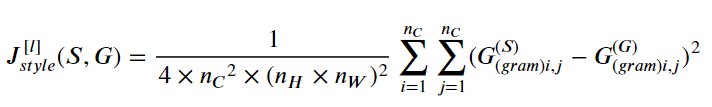
    - G^(S)_gram Gram matrix of the 'style' image.
    - G^(G)_gram Gram matrix of the 'generated' image.
    - Make sure we remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network a[l]
    
## compute_layer_style_cost() function
- Compute the style cost for a single layer.
- The 3 steps to implement the function are :
    1. Retrive dimensions from the hidden layer activations a_G :
    2. Unroll the hidden layer activations a_S and A_G into 2D matrix
    3. Compute the Style matrix of the image S and G.
    4. Compute the Style cost

In [12]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S, shape=[n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[n_H*n_W, n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = (1/(2*n_C*n_H*n_W)**2)*tf.reduce_sum(tf.square(GS-GG))
    
    return J_style_layer

### 4.2.3 Style weights
- We have captured the style from only one layer.
- We'll get better results if we 'merge' style costs from serveral different layers.
- Each layer will be givne weights (lambda[l]) that reflect how much each layer will cotnribute to the style.

In [14]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


- Get a look at the output of a layer block5_conv4.

In [15]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

- Now choose layers to represent the style of the image and assign style costs.

In [16]:
STYLE_LAYERS =[
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

- We can combine the style costs for different layers as follows :
    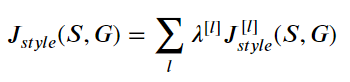
- where the values for lambda[l] are given in STYLE_LAYERS

## Compute_style_cost() function
- It calls our compute_layer_style_cost(..) several times, and weights their results using the values in STYLE_LAYERS
- For each layer :
    - select the activation (the output tensor) of the current layer.
    - Get the style of the style image 'S' from the current layer.
    - Get the style of the generated image 'G' from the current layer.
    - Compute the 'style cost' for the current layer.
    - Add the weighted style cost to the overall style cost (J_style)

In [17]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

- How do we choose the coefficents for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if we want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if we want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.

## 4.3 Defining the total cost to optimize
- Finally, we will create a cost function that minimized both the style and the content cost. The formula is 
    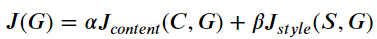

In [18]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha*J_content + beta*J_style
    return J

- The total cost is a linear combination of the content cost J_content(C, G) and the style cost J_style(S,G)
- Alpha and Beta are hyperparameters that control the relative weighting b/w content and style.

# 5. Solving the Optmization problem
- Finally we get to put everything together to implement Neural Style Transfer.
- We want our program to able to do :
    1. Load the content image
    2. Load the style image
    3. Randomly initialize the image to be generated.
    4. Load the VGG19 model
    5. Compute the content cost
    6. Compute the style cost
    7. Compute the total cost
    8. Define the optimizer and learning rate

## 5.1 Load the content image

(1, 400, 400, 3)


<IPython.core.display.Javascript object>

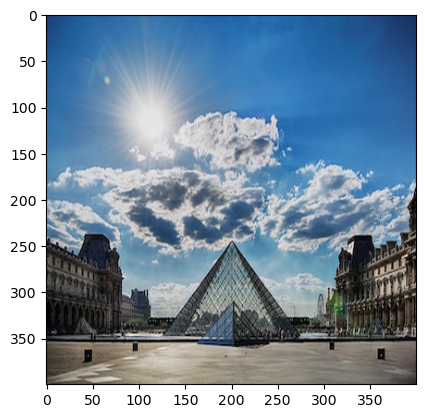

In [19]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

## 5.2 Load the style image

(1, 400, 400, 3)


<IPython.core.display.Javascript object>

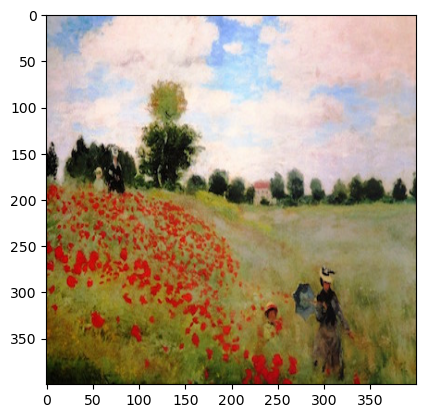

In [20]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

## 5.3 Randomly initialize the image to be Generated
- Now, we get to initialize the 'generated' image as a noisy image created from the content_image
    - The generated image is slightly correlated with the content image.
    - By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the generated image more rapidly match the content of the 'content' image.

(1, 400, 400, 3)


<IPython.core.display.Javascript object>

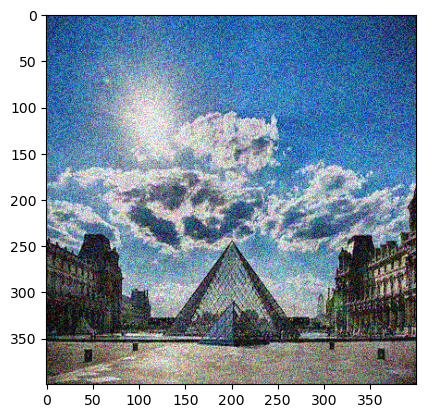

In [21]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

## 5.4 Load Pre-trained VGG19 Model
- Define a function which load the VGG19 model and returns a list of the output for the middle layers.

In [22]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [23]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [24]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

## 5.5 Compute Total Cost
### 5.5.1 Compute the content image Encoding (a_C)
- We've build the model, and now to compute the content cost, we will encode our content image using the approriate hidden layer activations. Set the encoding to the variable a_C

In [25]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

### 5.5.2 Compute the style image Encoding (a_S)

In [26]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [27]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

## train_step() function
- Implement the function for transfer learning
- Use the Adam optimizer to minimize the total cost J.
- Use a learning rate of 0.01
- Adam optimizer
- We will use tf.GradientTape to update the image.

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J

## 5.6 Train the Model

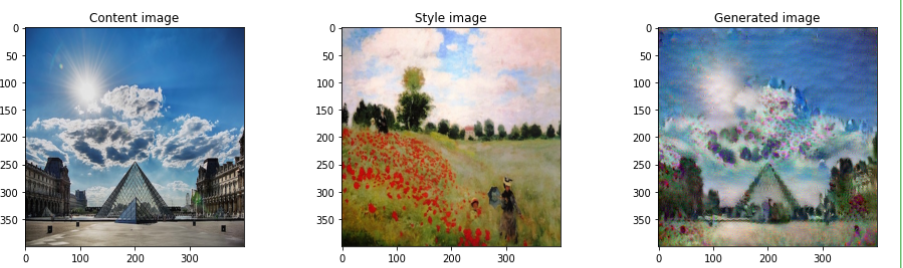

- Neural Style Transfer is an algorithm that gives a content image C and a style image S can generate an artistic image.
- It uses representations (hidden layer activations) based on a pretrained ConvNet.
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images.